# VS associations with cognitive performance (P) with an interaction with DRD2 polymorphism

***

Does the ventral striatal reactivity to rewards interact with the presence of the DRD2 (-141C Ins/Del) polymorphism to impact sensitivity to gains and losses during feedback learning?


In [64]:
import matplotlib.pyplot as plt
import ptitprince as pt
import pandas as pd
import numpy as np
import random
from scipy import stats
from scipy.stats import beta
from scipy.special import betaln
from statsmodels.compat import unicode
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from IPython.core.display import HTML
from IPython.display import Image
import pymc3 as pm
import math
import warnings
warnings.filterwarnings('ignore')

## Dopamine (DA) Receptor Differences

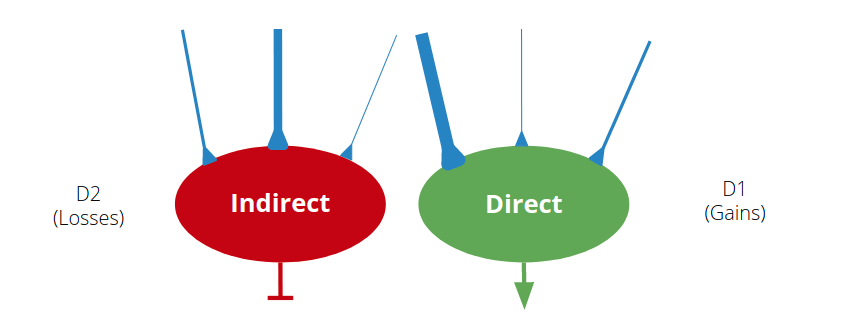

In [65]:
Image(filename="DA_pathways.png")

An insertion/deletion variant in the human dopamine receptor D2 (DRD2) gene associates with lower levels of D2 receptor density. 

Thus DRD2 carriers may be less sensitive to losses during feedback learning. 

## Iowa Gambling Task (IGT)

#### Payoff

    P = (C + D) - (A + B)
    
#### Sensitivity to high frequency rewards

    Q = (B + D) - (A + C)

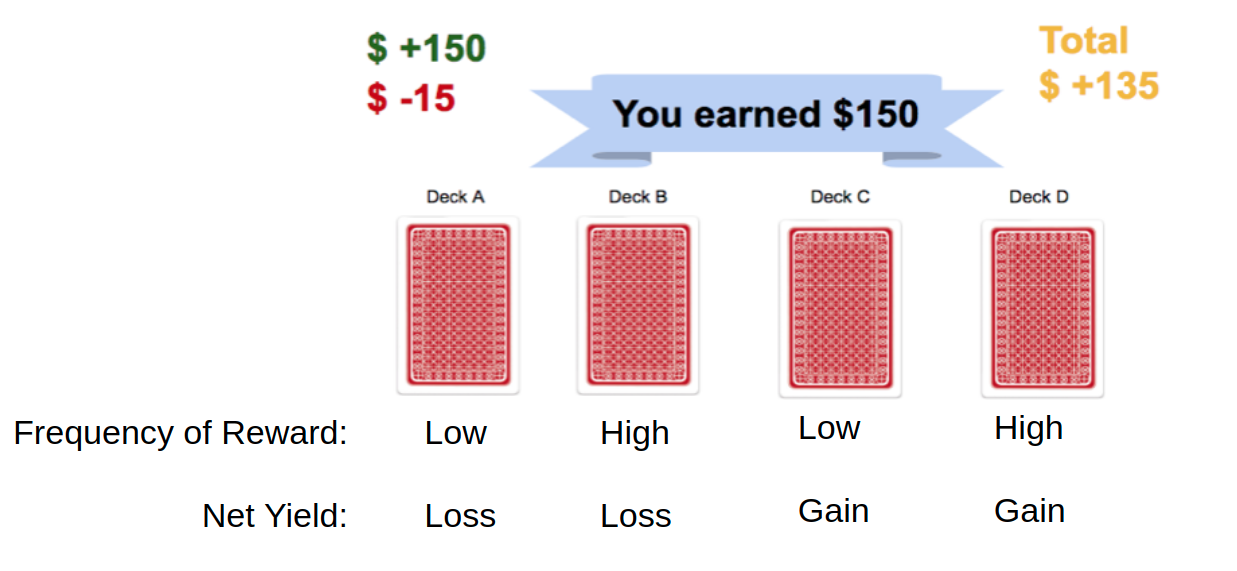

In [66]:
Image(filename="IGT_cards.png")

### Loading Datasets

In [44]:
# Loading data
data = pd.read_csv('DRD2_subset_data.csv', delimiter=',')
data = data.dropna(subset=['P','Q','VS','DRD2', 'AGE', 'female_1'])

# Loading second IGT only data (Reformatted)
IGT_data = pd.read_csv('DRD2_IGT_subset_data.csv', delimiter=',')
IGT_data = IGT_data.dropna(subset=['IGT_scores', 'DRD2'])

### Reformatting Data

In [45]:
# Changing Categorical data to integers
data['DRD2'] = data['DRD2'].astype(int)
data['female_1'] = data['female_1'].astype(int)
IGT_data['DRD2'] = IGT_data['DRD2'].astype(int)

# Changing DRD2 data to category type
data['DRD2_cat'] = pd.cut(data['DRD2'], range(-1,2,1), labels=['-141C Ins/Del Carrier', 'Non-Carrier'])
data['DRD2_cat'] = data['DRD2_cat'].astype('object')
IGT_data['DRD2_cat'] = pd.cut(IGT_data['DRD2'], range(-1,2,1), labels=['-141C Ins/Del Carrier', 'Non-Carrier'])
IGT_data['DRD2_cat'] = IGT_data['DRD2_cat'].astype('object')

# Splitting data based on DRD2 polymorphism
low = data[data['DRD2'] == 1] # Low D2 Receptors
normal = data[data['DRD2'] == 0] # Normal D2 Receptors

## Distribution Plots

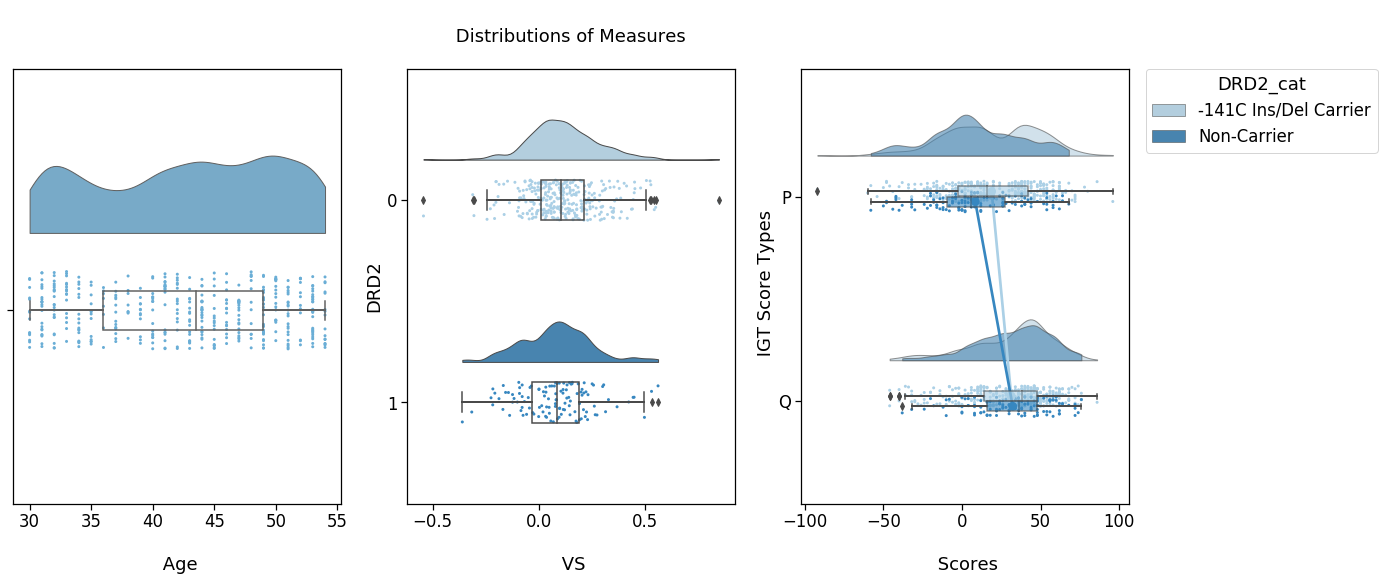

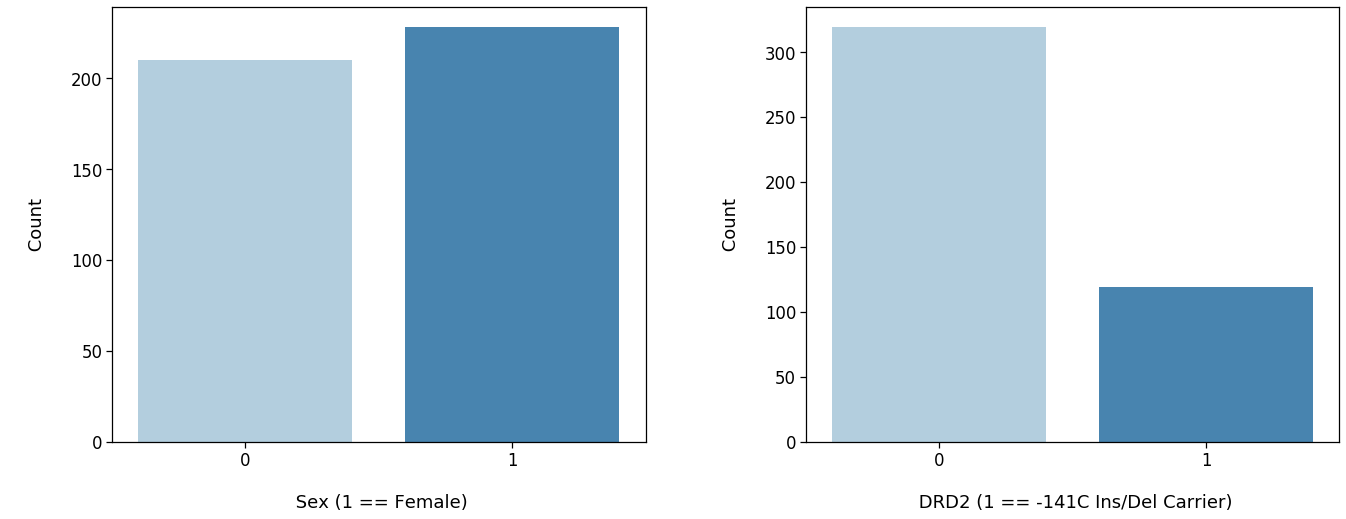

In [46]:
# Setting style of figures
sns.set_context("notebook", font_scale=1.5)

# Configuring 1st row of grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.set_figheight(8)
fig.set_figwidth(20)

# Age Rain Cloud Plot
ax = fig.add_subplot(1, 3, 1)
age = pt.RainCloud(y='AGE', orient='h',data=data, width_viol=.4, width_box=.1, figsize=(7,5), 
                   palette="Blues",ax=ax)
age.set(xlabel='\n Age')

# VS Rain Cloud Plot
ax = fig.add_subplot(1, 3, 2)
VS = pt.RainCloud(y='VS', x='DRD2', data=data, orient='h', width_viol=.4, width_box=.2, figsize=(7,5), 
                  palette="Blues", ax=ax)
VS.set(xlabel='\n VS', title='\n Distributions of Measures \n')

# IGT Scores Rain Cloud Plots
ax = fig.add_subplot(1, 3, 3)
IGT = pt.RainCloud(y='IGT_scores', x='IGT_score_type', hue='DRD2_cat', data=IGT_data, orient='h', 
                         width_viol=.4, width_box=.1, figsize=(7,5), palette='Blues', alpha=.6, ax=ax,
                          dodge=True, pointplot=True) #Can comment out if lines aren't helpful
IGT.set(xlabel='\n Scores', ylabel='\n IGT Score Types')

# Configuring 2nd row of grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=.3)
fig.set_figheight(8)
fig.set_figwidth(22)

# Sex Bar Plot
ax = fig.add_subplot(1, 2, 1)
sex = sns.catplot(x="female_1", kind="count", data=data, palette="Blues", ax=ax)
ax.set(xlabel='\n Sex (1 == Female)', ylabel='\n Count \n')

# DRD2 Bar Plot
ax = fig.add_subplot(1, 2, 2)
DRD2 = sns.catplot(x="DRD2", kind="count", data=data, palette="Blues", ax=ax)
ax.set(xlabel='\n DRD2 (1 == -141C Ins/Del Carrier)', ylabel='\n Count \n')
plt.close(3)
plt.close(4)
plt.show()

In a sample of neurologically healthy adults (N = 438), ventral striatal (VS) responses to rewards were measured using fMRI, genetic measures of the DRD2 polymorphism were run on all individuals, and cognitive performance was measured through the Iowa Gambling Task (IGT). 

***


# T-Tests

### T-Test between DRD2 vs P and Q

In [47]:
t_test_results = stats.ttest_ind(low.iloc[:,2:5], normal.iloc[:,2:5], equal_var=True)
cols = ['P', 'Q', 'VS']
pd.DataFrame({'Statistics':t_test_results.statistic[0:], 'P-values':t_test_results.pvalue}, cols)


,Statistics,P-values
P,-3.230837,0.001328
Q,0.539049,0.590128
VS,-1.771730,0.077138


DRD2 polymorphism carriers had generally lower performance in IGT than non-carriers 

### Linear Regression Plots

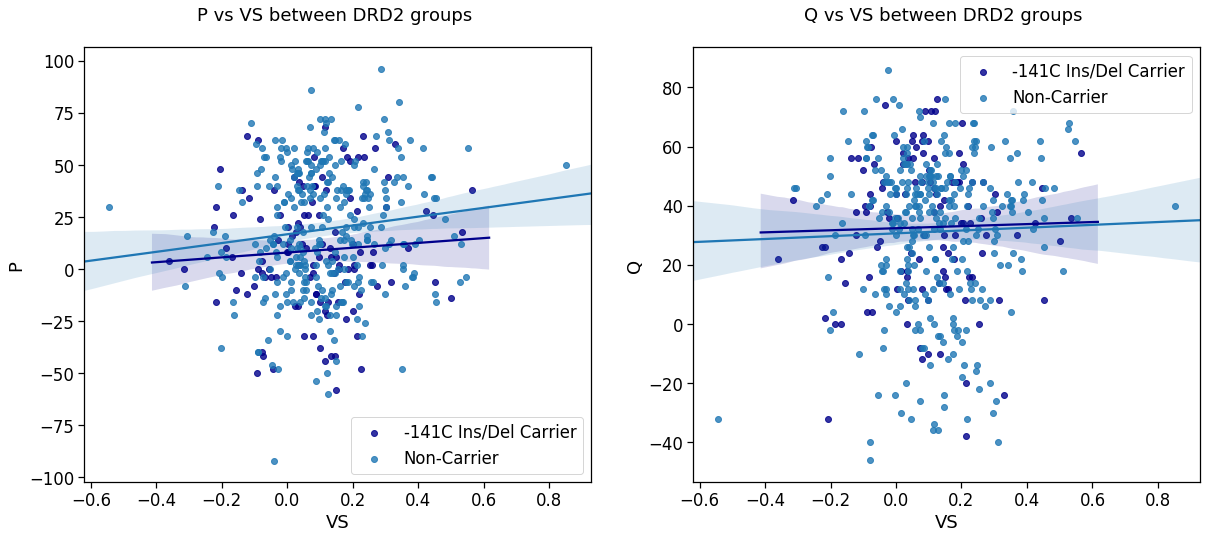

In [67]:
# Configuring grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.set_figheight(8)
fig.set_figwidth(20)

# P vs VS between DRD2 groups Scatter Plot
ax = fig.add_subplot(1, 2, 1)
scatter_P_low = sns.regplot(x='VS', y='P', data=low, label='-141C Ins/Del Carrier', 
                            color="darkblue", ax=ax).legend()
scatter_P_normal = sns.regplot(x='VS', y='P', data=normal, label='Non-Carrier').legend()
ax.set(title='P vs VS between DRD2 groups \n')

# Q vs VS between DRD2 groups Scatter Plot
ax = fig.add_subplot(1, 2, 2)
scatter_Q_low = sns.regplot(x='VS', y='Q', data=low, label='-141C Ins/Del Carrier', 
                            color="darkblue", ax=ax).legend()
scatter_Q_normal = sns.regplot(x='VS', y='Q', data=normal, label='Non-Carrier').legend()
ax.set(title='Q vs VS between DRD2 groups \n')
plt.show()

Non-carriers have a steeper slope compared to Carriers, which seems to provide evidence for the DRD2 x VS interaction for P

*****


# Linear Regression and Bayes Factor

## P ~ DRD2 + VS + DRD2 * VS

In [49]:
results_P_alt = sm.OLS.from_formula(formula='P ~ DRD2 + VS + DRD2 * VS',data=data).fit()
HTML(results_P_alt.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,16.7039,2.020,8.269,0.000,12.733,20.674
DRD2,-8.7905,3.634,-2.419,0.016,-15.932,-1.649
VS,21.1400,10.020,2.110,0.035,1.447,40.833
DRD2:VS,-9.5730,18.830,-0.508,0.611,-46.582,27.436


P-value for the null model P ~ DRD2 + VS is 0.611.

## P ~ DRD2 + VS

In [50]:
results_P_null = sm.OLS.from_formula(formula='P ~ DRD2 + VS',data=data).fit()
HTML(results_P_null.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,17.0188,1.921,8.858,0.000,13.243,20.795
DRD2,-9.6852,3.176,-3.049,0.002,-15.928,-3.442
VS,18.4295,8.476,2.174,0.030,1.770,35.089


## Bayes Factor for P Models

In [51]:
bayes_factor = math.exp((results_P_alt.bic - results_P_null.bic)/2)
print("Bayes Factor:", bayes_factor)

Bayes Factor: 18.370166786355266


Strong evidence against the alternative hypothesis (larger BIC value)

## Q ~ DRD2 + VS + DRD2 * VS

In [52]:
results_Q_alt = smf.ols(formula='Q ~ DRD2 + VS + DRD2 * VS',data=data).fit()
HTML(results_Q_alt.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.6606,1.746,17.563,0.000,27.230,34.092
DRD2,1.7348,3.140,0.553,0.581,-4.437,7.906
VS,4.7830,8.658,0.552,0.581,-12.234,21.801
DRD2:VS,-1.3082,16.272,-0.080,0.936,-33.289,30.673


## Q ~ DRD2 + VS

In [53]:
results_Q_null = smf.ols(formula='Q ~ DRD2 + VS',data=data).fit()
HTML(results_Q_null.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.7037,1.660,18.499,0.000,27.442,33.966
DRD2,1.6126,2.744,0.588,0.557,-3.781,7.006
VS,4.4126,7.322,0.603,0.547,-9.979,18.804


## Bayes Factor for Q Models

In [54]:
bayes_factor = math.exp((results_Q_alt.bic - results_Q_null.bic)/2)
print("Bayes Factor:", bayes_factor)

Bayes Factor: 20.860298419900293


Strong evidence against the alternative hypothesis

***

### Slope Comparison Between Groups

By running linear regression models for each group where P ~ VS

In [55]:
carrier = data[data['DRD2'] == 1]
noncarrier = data[data['DRD2'] == 0] 

## P ~  VS

#### Ins/Ins Carriers

In [56]:
results_P_carrier = smf.ols(formula='P ~ VS',data=carrier).fit()
HTML(results_P_carrier.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.9134,2.939,2.692,0.008,2.092,13.734
VS,11.5671,15.515,0.746,0.457,-19.159,42.293


#### Non-Carriers

In [57]:
results_P_noncarrier = smf.ols(formula='P ~ VS', data=noncarrier).fit()
HTML(results_P_noncarrier.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,16.7039,2.040,8.189,0.000,12.691,20.717
VS,21.1400,10.117,2.090,0.037,1.235,41.045


Coefficient is much greater for the Non-carriers than the Carriers 

## Q ~  VS

#### Ins/Ins Carriers

In [58]:
results_Q_carrier = smf.ols(formula='Q ~ VS',data=carrier).fit()
HTML(results_Q_carrier.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,32.3955,2.426,13.353,0.000,27.591,37.200
VS,3.4748,12.806,0.271,0.787,-21.887,28.837


#### Non-Carriers

In [59]:
results_Q_noncarrier = smf.ols(formula='Q ~ VS',data=noncarrier).fit()
HTML(results_Q_noncarrier.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.6606,1.789,17.139,0.000,27.141,34.180
VS,4.7830,8.873,0.539,0.590,-12.674,22.240


## Permutation Test on the Slope Comparison

In [60]:
np.random.seed(123)

def permutationTest(y, diff):
    
    diff_collection = []
    greaterDiff_count = 0
    total = 1500
    sample_size = 438
    
    for i in range(0, total):
        
        # Randomizing DRD2 Assignment
        DRD2_rand = np.random.choice(np.array(data['DRD2']), 438, replace = False)
        VS = np.array(data['VS'])
        y_data = np.array(data[y])
        perm_data = pd.DataFrame({'DRD2_rand':DRD2_rand, 'VS':VS, 'y':y_data})
        
        # Splitting by DRD2 Assignment
        carrier_rand_data = perm_data[perm_data['DRD2_rand'] == 1]
        noncarrier_rand_data = perm_data[perm_data['DRD2_rand'] == 0]
 
        # Carrier Linear Regression
        carrier_rand_res = smf.ols(formula = 'y ~ VS', data=carrier_rand_data).fit()
        carrier_coef = carrier_rand_res.params[1]
        
        # Non-Carrier Linear Regression
        noncarrier_rand_res = smf.ols(formula = 'y ~ VS', data=noncarrier_rand_data).fit()
        noncarrier_coef = noncarrier_rand_res.params[1]
        
        # Calculating Permuted Difference
        rand_diff = noncarrier_coef - carrier_coef
        
        # Collecting Permuted Differences
        diff_collection.append(rand_diff)
        
        # Counting Greater Permuted Differences 
        if rand_diff > diff:
            greaterDiff_count += 1
    
    # Calculating Fraction of Greater Permuted Differences
    PVal  = greaterDiff_count / total
    
    plt.hist(diff_collection, bins=25, edgecolor='k')
    plt.axvline(x=diff, color='black', linestyle='dashed')
    
    return PVal

0.30266666666666664

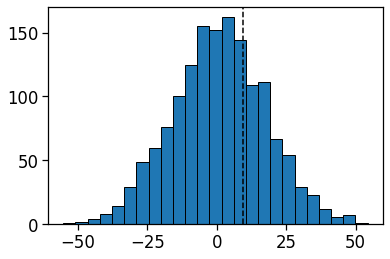

In [61]:
difference = results_P_noncarrier.params[1] - results_P_carrier.params[1]
permutationTest('P', difference)

0.4646666666666667

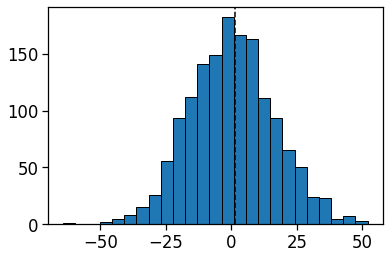

In [62]:
difference = results_Q_noncarrier.params[1] - results_Q_carrier.params[1]
permutationTest('Q', difference)

For these given models, there is a high probability of attaining the difference observed at random.